In [26]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import scipy.stats

from scipy.interpolate import interp1d

def hist_profile(x, y, bins, range_x, range_y) :

    w = (y>range_y[0]) & (y<range_y[1])
    
    means_result = scipy.stats.binned_statistic(x[w], [y[w], y[w]**2], bins=bins, range=range_x, statistic='mean')
    nb_entries_result = scipy.stats.binned_statistic(x[w], y[w], bins=bins, range=range_x, statistic='count')
    
    means, means2 = means_result.statistic
    nb_entries = nb_entries_result.statistic
    
    errors = np.sqrt(means2 - means**2)/np.sqrt(nb_entries)

    bin_edges = means_result.bin_edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

    return bin_centers, means, errors

def combine_u(method, u1, u1_err, u2, u2_err):

# combine u and u star

    u_comb = np.zeros(len(u))
    u_comb_err = np.zeros(len(u))

    if(method==1):
        for i in range (len(u_comb)):
            if(u1_err[i]<0.0 and u2_err[i]>0.0):
                u_comb[i] = u2[i]
                u_comb_err[i] = u2_err[i]
            elif(u1_err[i]>0.0 and u2_err[i]<0.0):
                u_comb[i] = u1[i]
                u_comb_err[i] = u1_err[i]
            elif(u1_err[i]>0.0 and u2_err[i]>0.0):
                w_u = u1_err[i]**(-2.0)/ (u1_err[i]**(-2.0) + u2_err[i]**(-2.0))
                w_u2 = u2_err[i]**(-2.0)/ (u1_err[i]**(-2.0) + u2_err[i]**(-2.0))
                u_comb[i] = w_u*u1[i] +  w_u2* u2[i]
                u_comb_err[i] = (u1_err[i]**(-2.0) + u2_err[i]**(-2.0))**(-1./2.)

    elif(method==2):
        for i in range (len(u_comb)):
            if(u1_err[i]<0.0 and u2_err[i]>0.0):
                u_comb[i] = u2[i]
                u_comb_err[i] = u2_err[i]
            elif(u1_err[i]>0.0 and u2_err[i]<0.0):
                u_comb[i] = u1[i]
                u_comb_err[i] = u1_err[i]
            elif(u1_err[i]<u2_err[i]>0.0):
                u_comb[i] = u1[i]
                u_comb_err[i] = u1_err[i]
            elif(u1_err[i]>u2_err[i]>0.0):
                u_comb[i] = u2[i]
                u_comb_err[i] = u2_err[i]   

    return u_comb, u_comb_err

####### Read fits file

# read V9
# Reduced catalog with mask==0, r<25, 
cat = fitsio.read('/global/cscratch1/sd/yeche/catalog/CLAUDS_COSMOS_v9_r25.fits',ext=1)


ra = cat['RA'][:]
dec = cat['DEC'][:]

# bands
u = cat['u'][:]
u_star = cat['uS'][:]

u_err = cat['u_err'][:]
u_star_err = cat['uS_err'][:]

g = cat['g'][:]
r = cat['r'][:]
z = cat['z'][:]
g_err = cat['g_err'][:]
r_err = cat['r_err'][:]
z_err = cat['z_err'][:]

g_r = g - r

# extended objects (HSC)
ext_hsc = cat['r_extendedness_value'][:]

# u vs u_star
flag_field_binary = cat['FLAG_FIELD_BINARY'][:]
in_u = flag_field_binary[:,1]
in_u_star = flag_field_binary[:,2]

# Vincent's fix
u[~(in_u)] = 0
u_err[~(in_u)] = -1.0   
u_star[~(in_u_star)] = 0
u_star_err[~(in_u_star)] = -1.0


# Photo_z
photo_z = cat['ZPHOT'][:]

print(' Number of objects in catalog',len(photo_z))

 Number of objects in catalog 723900


#############################
 ######## Fixed a and b  ######
 a =  0.22
 b =  -0.025
 ####################


(-0.2, 0.2)

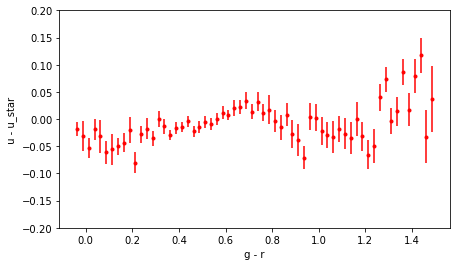

In [27]:
# linear correction of u and uS

print("#############################")
print(" ######## Fixed a and b  ######")
a = 0.22
b = -0.025
print(' a = ',a)
print(' b = ',b)
print(" ####################")

# use HSC stars
over =  in_u & in_u_star & (u_err>0.0) &  (u_err<2.0) & (u_star_err>0.0) &  (u_star_err<2.0)
sel_over = (ext_hsc==0) & over & (r<24.0)

u_star_cor = u_star +a*g_r + b

fig_1 = plt.figure(1,figsize=(7.0,4.0))

n_bins=62
x_inf = -.05
y_sup = 1.50  

bin_centers, means, errors = hist_profile(g_r[sel_over], (u[sel_over]-u_star_cor[sel_over]), bins=n_bins, range_x=(x_inf,y_sup), range_y=(-0.5,0.5))
plt.errorbar(x=bin_centers, y=means, yerr=errors, linestyle='none', marker='.',color='red', label="u - u_star_cor")

plt.ylabel(' u - u_star ')
plt.xlabel(' g - r ')
plt.ylim(-0.2,0.2)

##############################################
LBG target density (CLAUDS) =  937.2  deg^-2 
LBG target density (extension ) = 1039.8  deg^-2 
LBG target density (Total) = 1977.1  deg^-2 
###############################
LBG target density (CLAUDS), z<0.2 =   18.5  deg^-2 
LBG target density (extension 1), z<0.2 =   73.7  deg^-2 
LBG target density (Total) z<0.2 =   92.2  deg^-2 


(-0.01, 4.0)

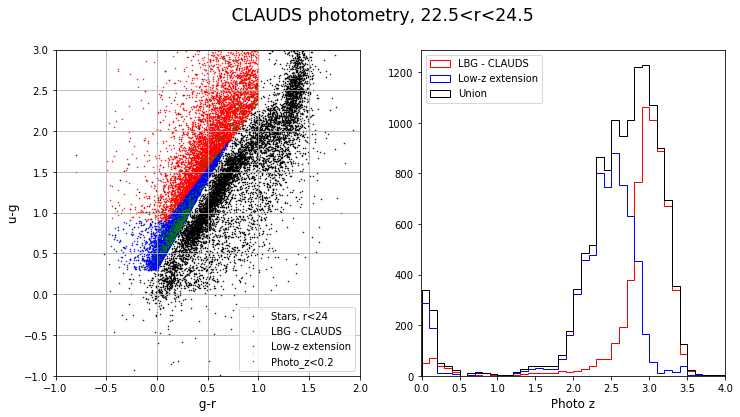

In [28]:
# combine u and u_star

u_comb, u_comb_err = combine_u(1, u, u_err, u_star_cor, u_star_err)
u_g = u_comb - g

# Selection
surface = 6.5  # deg^2 COSMOS  ~0.5 deg^2

# Star
star = (ext_hsc==0) & (r<24.0) & (u_comb_err>0) & (u_comb_err<10.0) & (u_comb>0.) & (g>0.) & (r>0.) &(g_err>0.) & (r_err>0.)  & (g_err<1.0) & (r_err<1.0)

#LBG
quality = (u_comb_err>0) & (u_comb_err<10.0) & (u_comb>0.) & (g>0.) & (r>0.) &(g_err>0.) & (r_err>0.)

color_box = (u_g>0.9) & (g_r<1.0) & (u_g>1.6*g_r+0.75)
color_box_ext = (u_g>0.3) & (u_g<2.0)  &  (u_g>2.2*g_r+0.32) & ~color_box

r_range = (r>22.5) & (r<24.5) & quality & (g_r>-0.5) # r ref
 
sel_LBG = color_box & r_range & (r_err<0.4) 
sel_LBG_ext = color_box_ext & r_range & (r_err<0.4) 



print('##############################################')
print('LBG target density (CLAUDS) = {:6.1f}'.format(float(np.sum(sel_LBG))/surface),' deg^-2 ')
print('LBG target density (extension ) = {:6.1f}'.format(float(np.sum(sel_LBG_ext))/surface),' deg^-2 ')
print('LBG target density (Total) = {:6.1f}'.format(float(np.sum(sel_LBG|sel_LBG_ext))/surface),' deg^-2 ')
print('###############################')
print('LBG target density (CLAUDS), z<0.2 = {:6.1f}'.format(float(np.sum(sel_LBG&(photo_z<0.2)))/surface),' deg^-2 ')
print('LBG target density (extension 1), z<0.2 = {:6.1f}'.format(float(np.sum(sel_LBG_ext&(photo_z<0.2)))/surface),' deg^-2 ')
print('LBG target density (Total) z<0.2 = {:6.1f}'.format(float(np.sum((sel_LBG|sel_LBG_ext)&(photo_z<0.2)))/surface),' deg^-2 ')

fig_3 = plt.figure(3,figsize=(12.0,6.0))
fig_3.suptitle(' CLAUDS photometry, 22.5<r<24.5',fontsize='xx-large')

plt.subplot(121)

plt.scatter(x=g_r[star],y=u_g[star], s=1, marker='.', color='black', label='Stars, r<24')
plt.scatter(x=g_r[sel_LBG],y=u_g[sel_LBG], s=1, marker='.', color='red', label='LBG - CLAUDS ')
plt.scatter(x=g_r[sel_LBG_ext],y=u_g[sel_LBG_ext], s=1, marker='.', color='blue', label='Low-z extension')

plt.scatter(x=g_r[(sel_LBG_ext|sel_LBG)&(photo_z<0.2)],y=u_g[(sel_LBG_ext|sel_LBG)&(photo_z<0.2)], s=1, marker='.', color='green', label='Photo_z<0.2')

plt.xlabel(' g-r ',fontsize='large')
plt.ylabel(' u-g ',fontsize='large')

plt.xlim((-1.0,2.0))
plt.ylim((-1.0,3.0))

plt.grid()

plt.legend(loc='lower right')

plt.subplot(122)

plt.hist(photo_z[sel_LBG], bins=40, color='red', range=(0.,4.0), histtype='step', label='LBG - CLAUDS')

plt.hist(photo_z[sel_LBG_ext], bins=40, color='blue', range=(0.,4.0), histtype='step', label='Low-z extension')
plt.hist(photo_z[sel_LBG_ext|sel_LBG], bins=40, color='black', range=(0.,4.0), histtype='step', label='Union')


plt.xlabel(' Photo z ',fontsize='large')

plt.legend(loc='upper left')
plt.xlim((-0.01,4.0))

In [29]:
# write fits file


sel = sel_LBG | sel_LBG_ext

zeros = np.zeros(len(ra[sel]))
falses = np.zeros(len(ra[sel]),dtype=bool)

print('##########################')
print(' number of selected Targets ',np.sum(sel))      

fits = fitsio.FITS('LBG_targets_in_COSMOS.fits','rw',clobber=True)
array_list=[ra[sel],dec[sel],zeros,zeros,zeros,falses,u_comb[sel],u_comb_err[sel],g[sel],g_err[sel],r[sel],r_err[sel],photo_z[sel]]
names=['RA','DEC','PMRA','PMDEC','REF_EPOCH','OVERRIDE','u','u_err','g','g_err','r','r_err','photo_z']
fits.write(array_list, names=names)
fits.close()




##########################
 number of selected Targets  12851
